In [1]:
from ptlpinns.odes import equations, numerical
from ptlpinns.models import model, transfer
import numpy as np
import time
import torch
from ptlpinns.perturbation import LPM, standard
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

Note: computational time scales with N for PINNs but not for the numerical solvers

In [2]:
N_ITER = 25

N = 5120
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)

RK45_time, Radau_time, PTL_PINN_inverting, PTL_PINN_not_inverting = [], [], [], []

In [3]:
zeta_list = [0, 0.5, 5]

w_list_transfer = [1, 1, 1]

forcing_names = ['']

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.zeros_like(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.zeros_like(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

def zeroes_1D(t):
    return np.zeros_like(t)

forcing_1D = [zeroes_1D, zeroes_1D, zeroes_1D]

ic_list = [[1, 0], [1, 0], [1, 0]]
p_list = [[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]]
epsilon_list = [0.5, 0.5, 0.5]
q = [(3, 1)]
alpha_list = [0.2]
ic_lkv = [1.59, 0.95 ]

### RK45 and Radau times

In [4]:
RK45_solution = []

for i, zeta in enumerate(zeta_list):

    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[i], zeta=zeta, forcing_1D=forcing_1D[i], q=q, epsilon=0.5)
    RK45_sol = numerical.solve_ode_equation(ode, t_span, t_eval, ic_list[i], method="RK45", rtol=1e-5, atol=1e-5)
    RK45_solution.append(RK45_sol[0, :])

### PTL-PINNs

In [5]:
undamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/undamped_k12"
undamped_name = "model_undamped_k12.pth"
undamped_model, _ = model.load_model(undamped_path, undamped_name)

underdamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/underdamped_k12"
underdamped_name = "model_underdamped_k12.pth"
underdamped_model, _ = model.load_model(underdamped_path, underdamped_name)

overdamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/overdamped_k12"
overdamped_name = "model_overdamped_k15.pth"
overdamped_model, _ = model.load_model(underdamped_path, underdamped_name)

12 True True True 1.0 16 [256, 256, 512]
12 True True True 1.0 16 [128, 128, 256]
12 True True True 1.0 16 [128, 128, 256]


In [6]:
# Compute latent representation: H(t) and derivatives
H_dict_undamped = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=(t_span[0], t_span[1]))
H_dict_underdamped = transfer.compute_H_dict(underdamped_model, N=N, bias=True, t_span=(t_span[0], t_span[1]))
H_dict_overdamped = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=(t_span[0], t_span[1]))

training_log = {'w_ode': 1.5, 'w_ic': 1}

In [7]:
time_list, sol_list = [], []

for i in range(len(zeta_list)):

    print("solving for zeta =", zeta_list[i])

    time_zeta_list, sol_zeta_list = [], []

    for j in range(N_ITER):

        if zeta_list[i] == 0:
            solver = "LPM"
            H_dict = H_dict_undamped
        elif 0 < zeta_list[i] < 1:
            solver = "standard"
            H_dict = H_dict_underdamped
        else:
            solver = "standard"
            H_dict = H_dict_overdamped 

        _, _, _ = transfer.compute_perturbation_solution([w_list_transfer[i]], [zeta_list[i]], [epsilon_list[i]], p_list[i],
                                [ic_list[i]], [forcing_list[i]], H_dict,
                                t_eval, training_log, all_p=True, comp_time=True,
                                solver=solver, w_sol = [], invert=True)

        # invert = False
        NN_TL_solution, perturbation_solution, TL_time_not_inverting = transfer.compute_perturbation_solution([w_list_transfer[i]], [zeta_list[i]], [epsilon_list[i]], p_list[i],
                                                                [ic_list[i]], [forcing_list[i]], H_dict,
                                                                t_eval, training_log, all_p=True, comp_time=True,
                                                                solver=solver, w_sol = [], invert=False)
        
        time_zeta_list.append(TL_time_not_inverting)
        sol_zeta_list.append(NN_TL_solution.squeeze()[:, :, 0])

    time_list.append(time_zeta_list) # shape: (3, NITER, 6)
    sol_list.append(sol_zeta_list) # shape: (3, NITER, 6, 512)

solving for zeta = 0
solving for zeta = 0.5
solving for zeta = 5


In [8]:
# RK45_solution - shape: (3, 512)
# sol_list.append - shape: (3, NITER, 6, 512)
sol_list = np.array(sol_list)
RK45_solution = np.array(RK45_solution)
error = sol_list - RK45_solution[:, np.newaxis, np.newaxis, :]

In [9]:
time_LKV_list = []

for j in range(N_ITER):

    _, _, _ = transfer.compute_perturbation_solution_LKV([epsilon_list[0]], p_list[0], ic_lkv, alpha_list, H_dict_undamped, t_eval, training_log, all_p=True, comp_time=True, invert=True, w_sol = [])
    _, _, TL_time_not_inverting = transfer.compute_perturbation_solution_LKV([epsilon_list[0]], p_list[0], ic_lkv, alpha_list, H_dict_undamped, t_eval, training_log, all_p=True, comp_time=True, invert=False, w_sol = [])
    time_LKV_list.append(TL_time_not_inverting)

time_list.append(time_LKV_list)

In [10]:
time_list = np.mean(time_list, axis=1)

/tmp/ipykernel_82095/1250760217.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", mean_time_per_correction.shape[0])


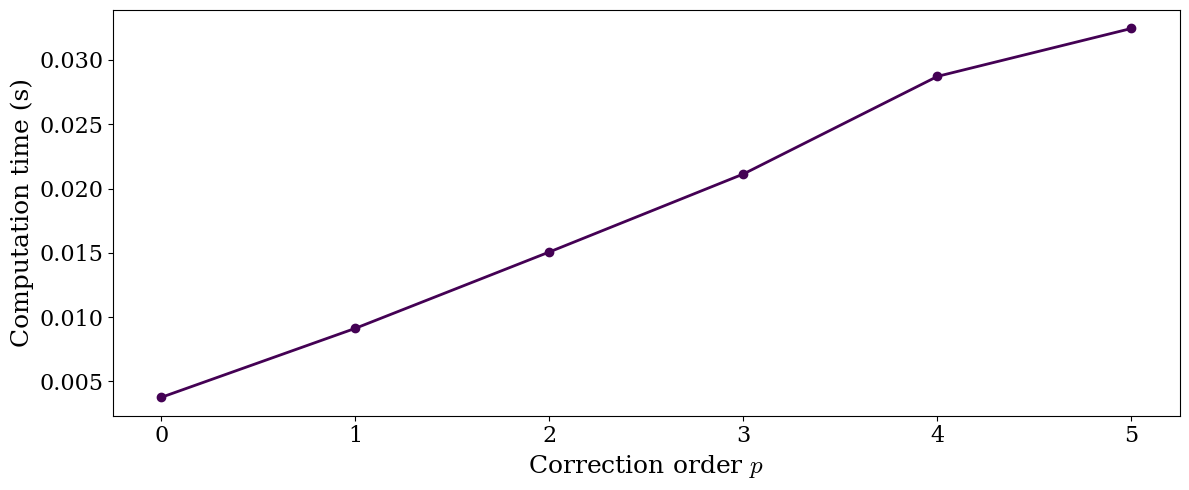

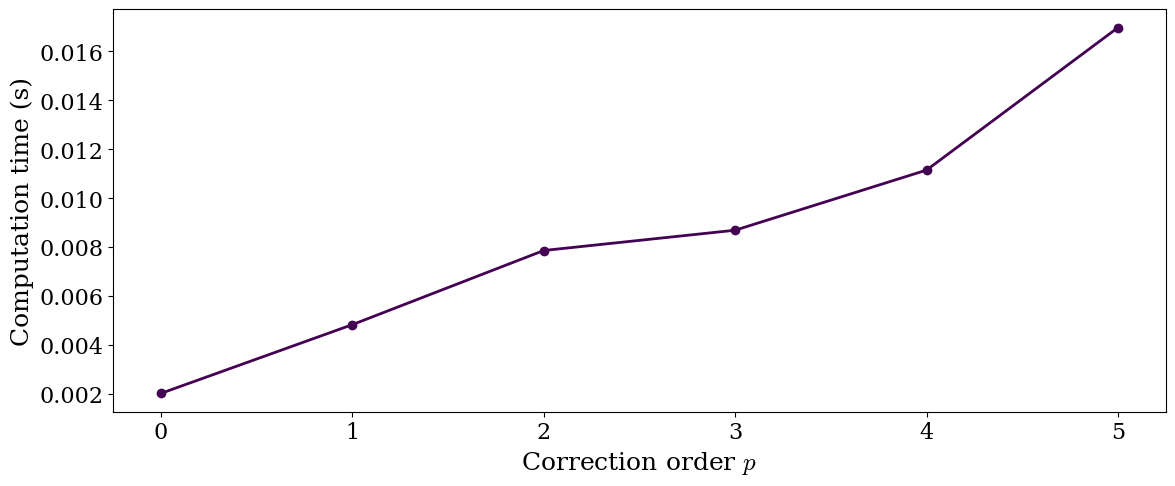

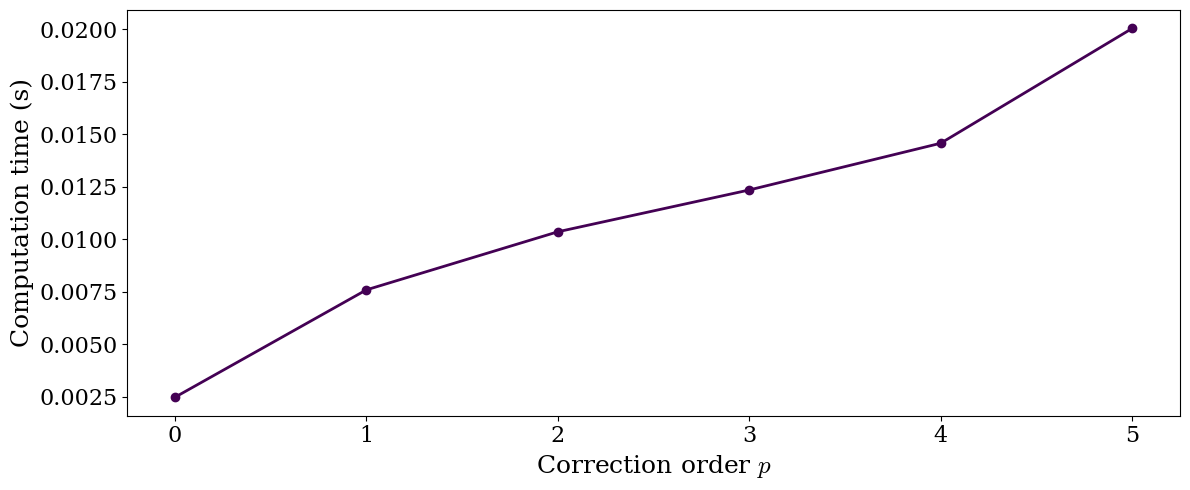

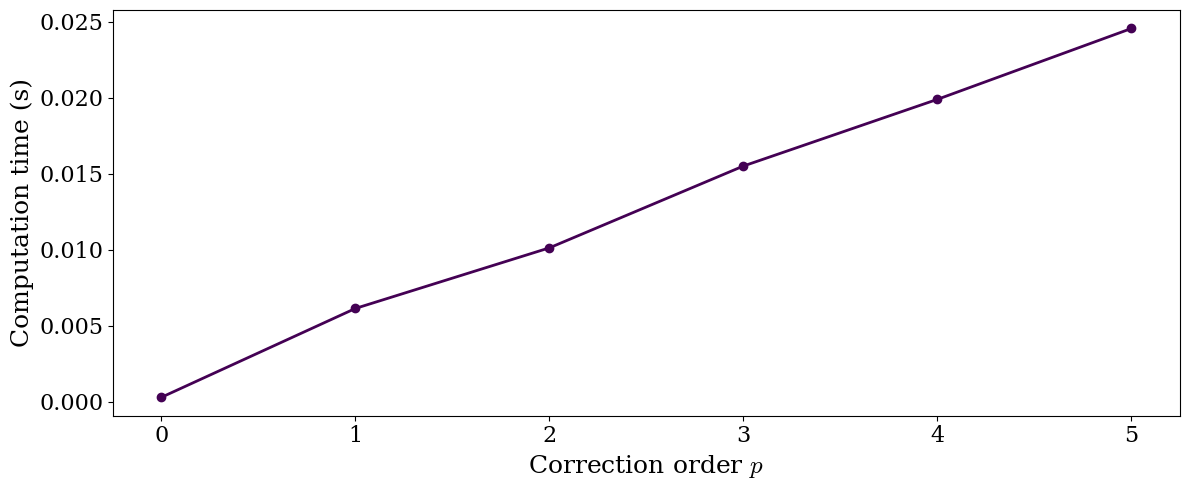

In [11]:
mean_time_per_correction = time_list

# --- Colormap ---
cmap = cm.get_cmap("viridis", mean_time_per_correction.shape[0])

# --- Loop over damping levels ---
for i in range(mean_time_per_correction.shape[0]):
    fig, ax = plt.subplots(figsize=(12, 5))

    base_color = cmap(0 / (mean_time_per_correction.shape[0] - 1))
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * 0 / (mean_time_per_correction.shape[0] - 1))

    ax.plot(
        np.arange(mean_time_per_correction.shape[1]),
        mean_time_per_correction[i],
        marker='o',
        linewidth=2.0,
        color=base_color,
    )

    ax.set_xlabel("Correction order $p$", fontsize=18)
    ax.set_ylabel("Computation time (s)", fontsize=18)
    ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()


In [27]:
lotka_error = [np.float64(0.07951072548723051),
 np.float64(0.040926989832407064),
 np.float64(0.014328715879967723),
 np.float64(0.010738954828925014),
 np.float64(0.004325202732761605),
 np.float64(0.005319806832378197),]

undamped_error = [np.float64(0.7649506983316541),
 np.float64(0.0942093915123104),
 np.float64(0.026140899153549363),
 np.float64(0.009359782741373291),
 np.float64(0.004030721612261331),
 np.float64(0.0017640573548029738),]

underdamped_error = [np.float64(0.1786921255051227),
 np.float64(0.08586624641594187),
 np.float64(0.04030161518681631),
 np.float64(0.03620189781926998),
 np.float64(0.023251850008531805),
 np.float64(0.019475200794424607)]

overdamped_error = [np.float64(0.07257264330743178),
 np.float64(0.01658691602959131),
 np.float64(0.005221626326257346),
 np.float64(0.0014156293299512706),
 np.float64(0.0008586293260226806),
 np.float64(0.00018864553809137949)]

error = np.array([undamped_error, underdamped_error, overdamped_error, lotka_error])

/tmp/ipykernel_82095/568879427.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", error.shape[0])


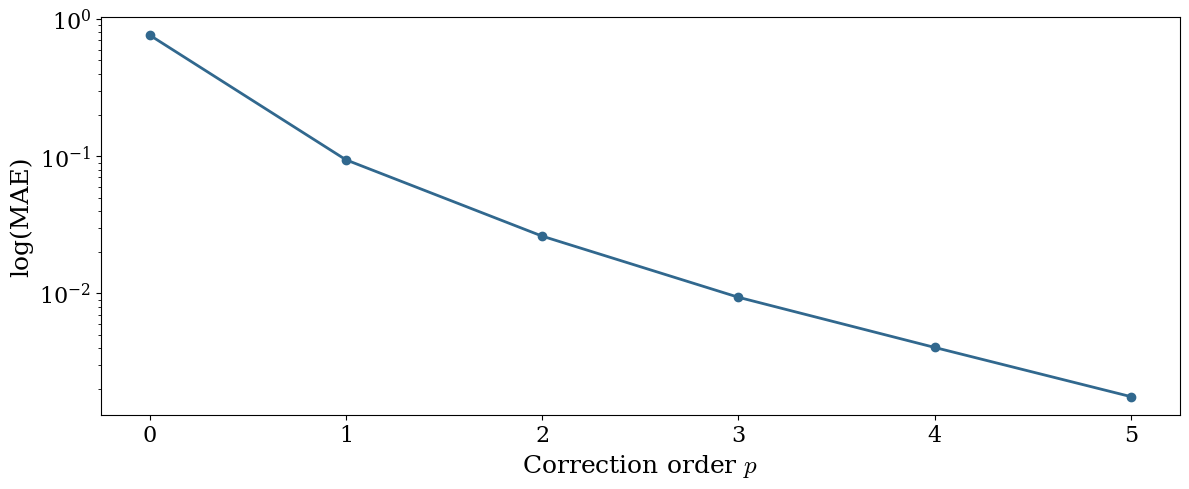

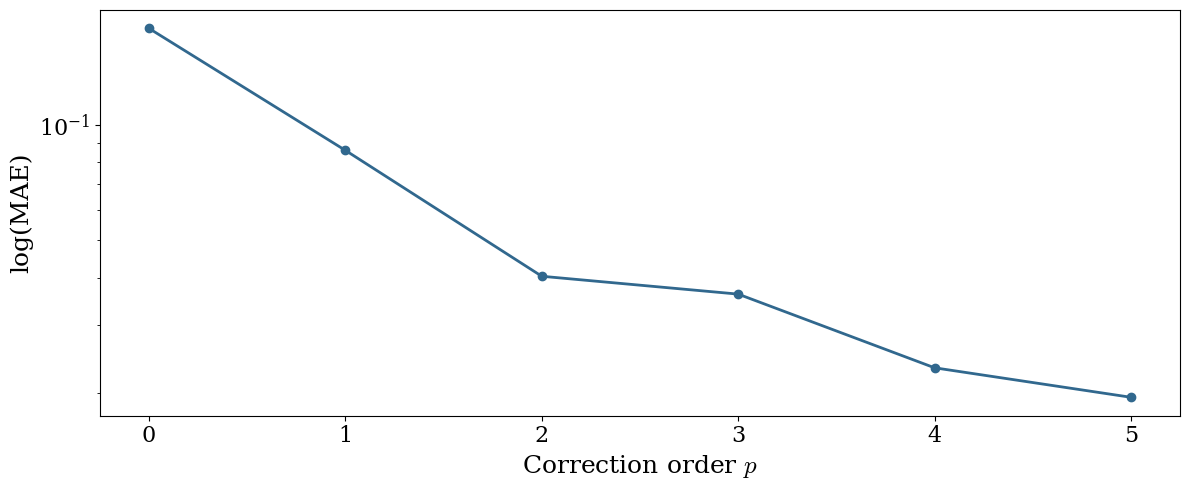

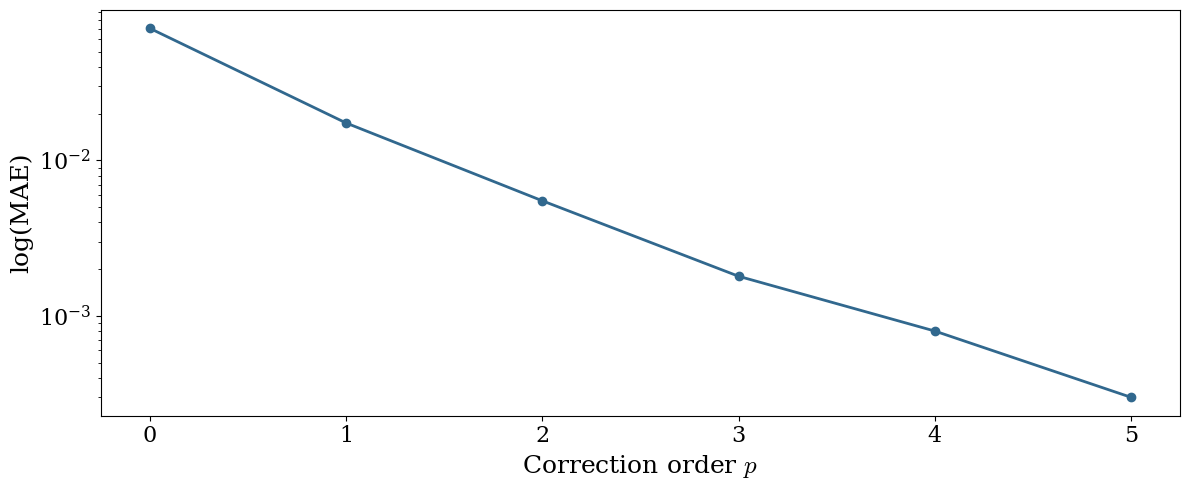

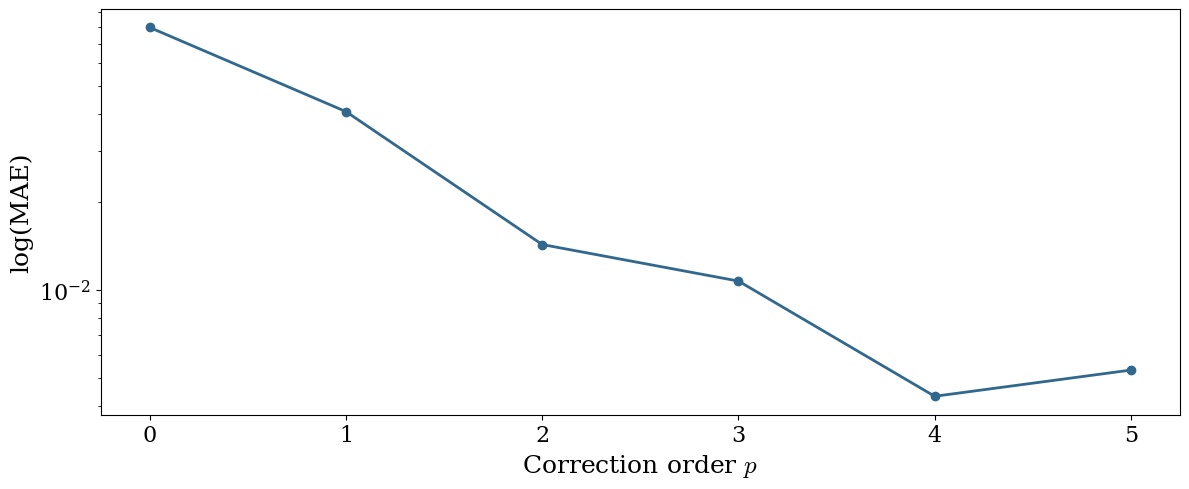

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Colormap ---
cmap = cm.get_cmap("viridis", error.shape[0])

# --- Loop over damping levels ---
for i in range(error.shape[0]):
    fig, ax = plt.subplots(figsize=(12, 5))

    base_color = cmap(1 / (error.shape[0] - 1))
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / (error.shape[0] - 1))

    ax.plot(
        np.arange(error.shape[1]),
        error[i],
        marker='o',
        linewidth=2.0,
        color=base_color,
    )

    ax.set_yscale('log')
    ax.set_xlabel("Correction order $p$", fontsize=18)
    ax.set_ylabel("log(MAE)", fontsize=18)
    ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_82095/40502671.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", error.shape[0])


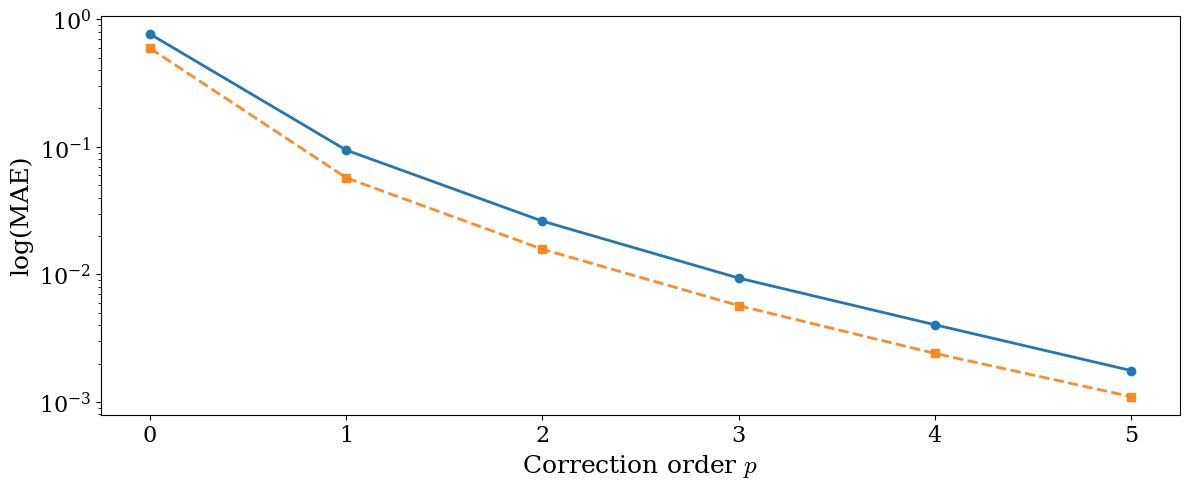

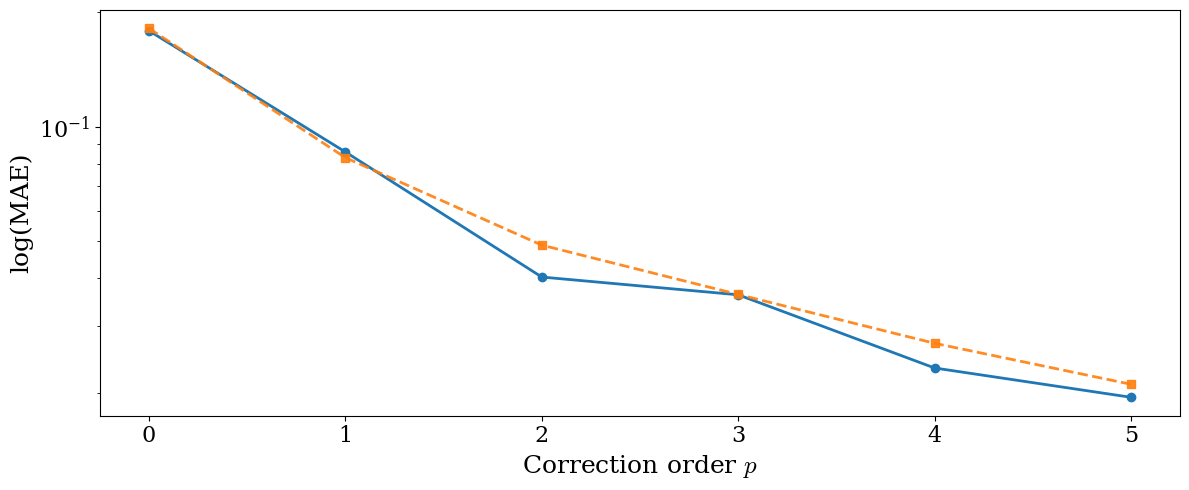

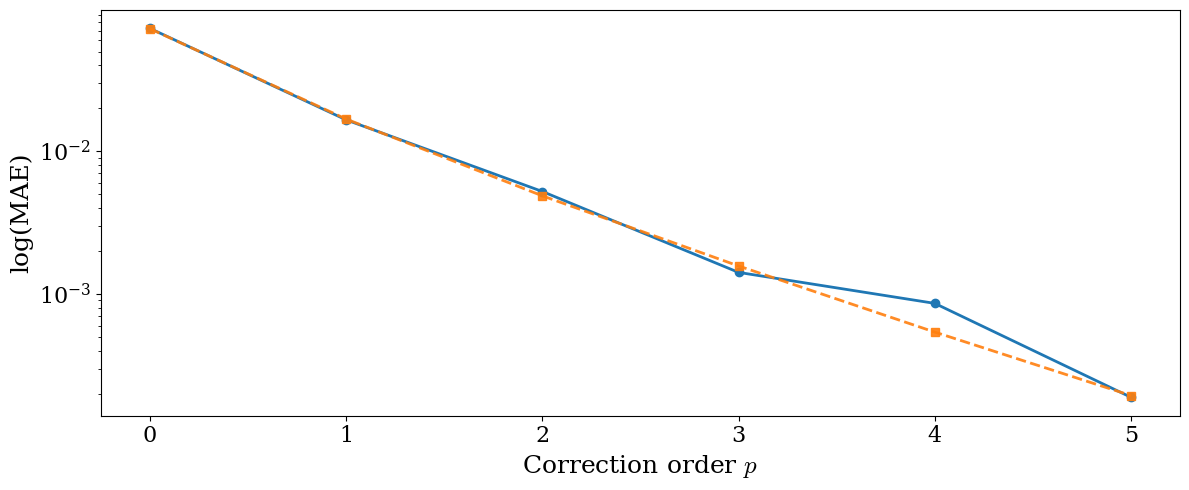

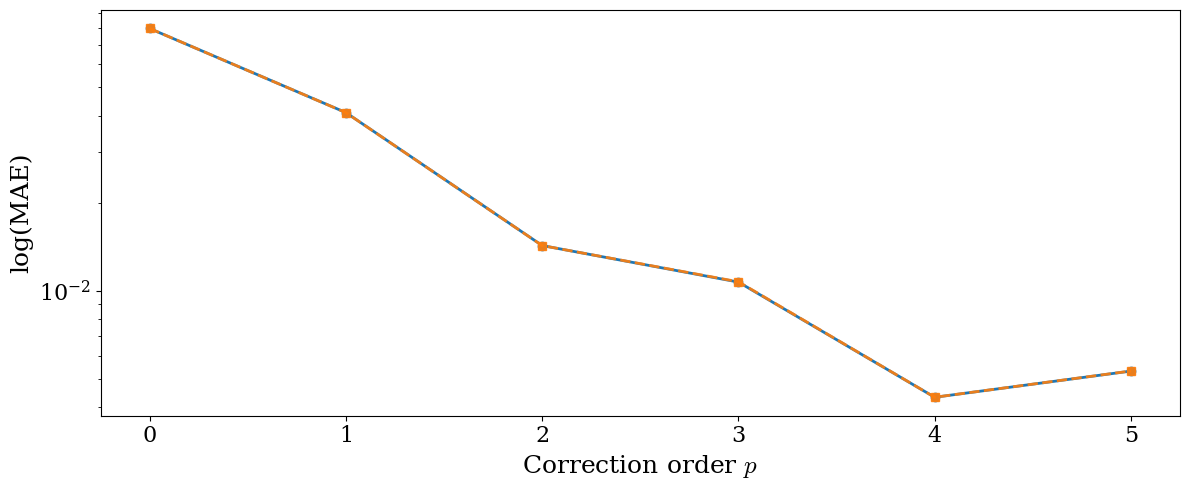

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

lotka_error_num = [np.float64(0.07954102394995057),
 np.float64(0.04091138036830193),
 np.float64(0.014326201207678045),
 np.float64(0.010766435650879853),
 np.float64(0.004325694923080198),
 np.float64(0.00532324558449083),]

undamped_error_num = [np.float64(0.591447637242471),
 np.float64(0.05712742219173585),
 np.float64(0.015754862751925714),
 np.float64(0.005694700709167257),
 np.float64(0.0024034755696546077),
 np.float64(0.0011017363597167448),]

underdamped_error_num = [np.float64(0.18127142018921252),
 np.float64(0.08297222102122584),
 np.float64(0.04888206972557724),
 np.float64(0.03627518252732536),
 np.float64(0.026997226751478157),
 np.float64(0.021069251679473974)]

overdamped_error_num = [np.float64(0.07221368531106587),
 np.float64(0.01681070939364242),
 np.float64(0.004868415332186938),
 np.float64(0.001570274192388969),
 np.float64(0.0005403160092127149),
 np.float64(0.00019412335783178085),]

error_dash = np.array([undamped_error_num, underdamped_error_num, overdamped_error_num, lotka_error_num])

# --- Colormap (still available if you want custom colors) ---
cmap = cm.get_cmap("viridis", error.shape[0])

# --- Loop over damping levels ---
for i in range(error.shape[0]):

    fig, ax = plt.subplots(figsize=(12, 5))

    p_range = np.arange(error.shape[1])

    # --- solid line: model ---
    ax.plot(
        p_range,
        error[i],
        marker='o',
        linewidth=2.0,
        label="model",
    )

    # --- dashed line: baseline (different marker + linestyle) ---
    ax.plot(
        p_range,
        error_dash[i],
        marker='s',           # square marker
        linestyle='--',
        linewidth=2.0,
        alpha=0.9,
        label="baseline",
    )

    ax.set_yscale('log')
    ax.set_xlabel("Correction order $p$", fontsize=18)
    ax.set_ylabel("log(MAE)", fontsize=18)
    ax.tick_params(labelsize=16)
    
    plt.tight_layout()
    plt.show()
